In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/ST/stargan

Mounted at /content/drive
/content/drive/MyDrive/ST/stargan


In [2]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import os

seed = 2710
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
class MultiBranchClassifier(nn.Module):
    def __init__(self, num_domains=4, num_classes=5, num_timesteps=128):
        super(MultiBranchClassifier, self).__init__()
        # Shared layers as before
        self.conv1 = nn.Conv1d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.fc_shared = nn.Linear(num_timesteps * 8, 100)

        # Prepare class-specific branches as a single module with conditionally applied outputs
        self.fc_class_branches = nn.Linear(100, 50 * num_classes)
        self.fc_final = nn.Linear(50, num_domains * num_classes)

    def forward(self, x, class_ids):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc_shared(x))

        # Process all class-specific branches simultaneously
        class_branches = self.fc_class_branches(x).view(x.size(0), -1, 50)
        class_outputs = class_branches[torch.arange(class_branches.size(0)), class_ids]

        # Final class-specific output
        final_outputs = self.fc_final(class_outputs.view(x.size(0), 50))
        return final_outputs.view(x.size(0), -1)


def split_data(x, y, k, test_size=0.2, random_state=seed):
    x_train, x_test, y_train, y_test, k_train, k_test = train_test_split(x, y, k,
                                                                         test_size=test_size,
                                                                         random_state=random_state,
                                                                         stratify=k,
                                                                         shuffle=True)
    return x_train, x_test, y_train, y_test, k_train, k_test


def setup_training(x_train, y_train, k_train, x_test, y_test, k_test, batch_size=64):
    # Convert numpy arrays to torch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    k_train_tensor = torch.tensor(k_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    k_test_tensor = torch.tensor(k_test, dtype=torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor, k_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor, k_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader


def evaluate_model(model, test_loader, loss_fn, device='cpu'):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for x_batch, y_batch, k_batch in test_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            outputs = model(x_batch, y_batch)
            loss = loss_fn(outputs, k_batch)
            total_loss += loss.item()

            # Assuming outputs are logits and k_batch are the true labels
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == k_batch).sum().item()
            total_predictions += k_batch.size(0)

    total_loss /= len(test_loader)
    accuracy = correct_predictions / total_predictions

    return total_loss, accuracy


def train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=300, name='domain_classifier'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_train = []
    loss_test = []
    accuracy_test = []
    best_loss = np.inf

    # Set up linear learning rate decay
    lambda_lr = lambda epoch: 1 - epoch / epochs
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, k_batch in train_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch, y_batch)
            loss = loss_fn(outputs, k_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(train_loader)
        loss_train.append(total_loss)

        # Update learning rate
        scheduler.step()

        test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device=device)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict().copy()
        loss_test.append(test_loss)
        accuracy_test.append(test_accuracy)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {total_loss:.4f} - Test loss: {test_loss:.4f} - Test accuracy: {test_accuracy:.4f} - LR: {current_lr:.6f}")

    # Save best model
    os.makedirs('pretrained_nets', exist_ok=True)
    if best_model is not None:
        print(f"Saving best model at epoch {np.argmin(loss_test) + 1} and test loss {best_loss:.4f}")
        torch.save(best_model, f"pretrained_nets/{name}.ckpt")
    else:
        print("No best model found, saving current model")
        torch.save(model.state_dict(), f"pretrained_nets/{name}.ckpt")

    return loss_train, loss_test, accuracy_test


(7817, 3, 128) (7817,) (7817,)
(6253, 3, 128) (1564, 3, 128) (6253,) (1564,) (6253,) (1564,)
Epoch 1/300 - Train loss: 2.9417 - Test loss: 2.0896 - Test accuracy: 0.3357 - LR: 0.000100
Epoch 2/300 - Train loss: 1.6749 - Test loss: 1.3212 - Test accuracy: 0.6311 - LR: 0.000099
Epoch 3/300 - Train loss: 1.1322 - Test loss: 0.9389 - Test accuracy: 0.7679 - LR: 0.000099
Epoch 4/300 - Train loss: 0.8168 - Test loss: 0.6789 - Test accuracy: 0.8254 - LR: 0.000099
Epoch 5/300 - Train loss: 0.5898 - Test loss: 0.4968 - Test accuracy: 0.8734 - LR: 0.000098
Epoch 6/300 - Train loss: 0.4353 - Test loss: 0.3713 - Test accuracy: 0.8996 - LR: 0.000098
Epoch 7/300 - Train loss: 0.3262 - Test loss: 0.2922 - Test accuracy: 0.9111 - LR: 0.000098
Epoch 8/300 - Train loss: 0.2559 - Test loss: 0.2431 - Test accuracy: 0.9265 - LR: 0.000097
Epoch 9/300 - Train loss: 0.2071 - Test loss: 0.2077 - Test accuracy: 0.9373 - LR: 0.000097
Epoch 10/300 - Train loss: 0.1742 - Test loss: 0.1757 - Test accuracy: 0.9501 -

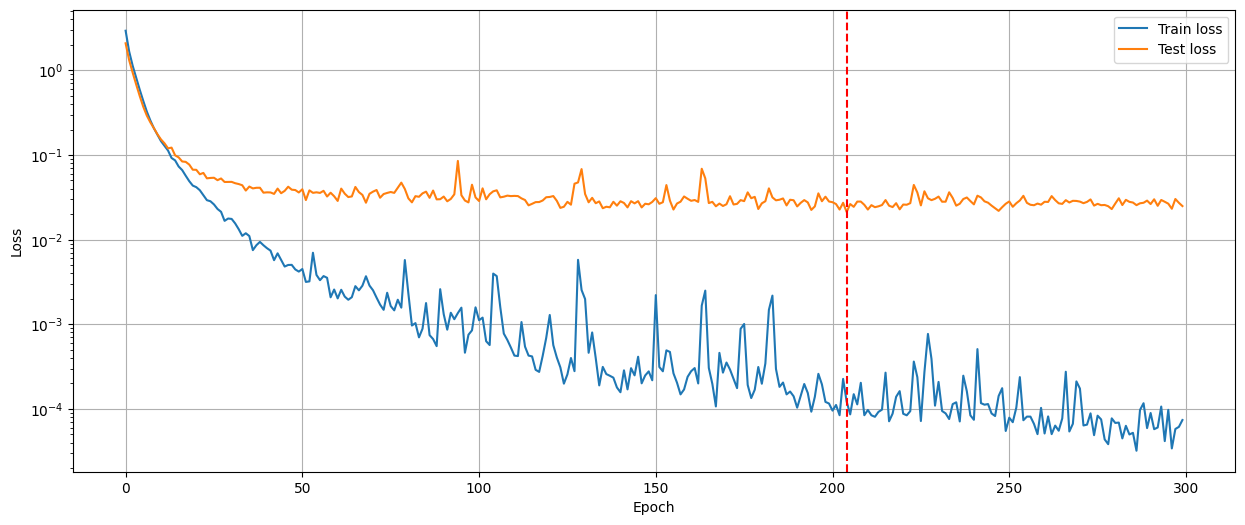

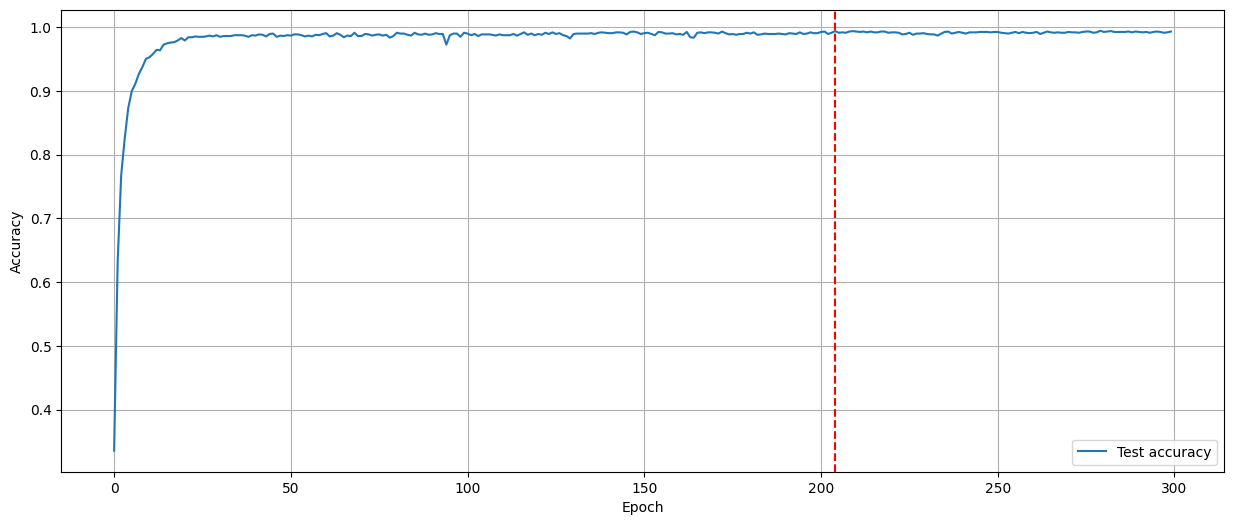

In [4]:
# Train domain classifier on Df (RealWorld)


with open('data/realworld_128_3ch_4cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < 10]
y = y[k < 10]
k = k[k < 10]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=10, num_classes=4, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = nn.CrossEntropyLoss()

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=300, name='domain_classifier_realworld_tr')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

(3866, 3, 128) (3866,) (3866,)
(3092, 3, 128) (774, 3, 128) (3092,) (774,) (3092,) (774,)
Epoch 1/300 - Train loss: 2.4892 - Test loss: 2.1662 - Test accuracy: 0.3036 - LR: 0.000100
Epoch 2/300 - Train loss: 1.4554 - Test loss: 1.1401 - Test accuracy: 0.6240 - LR: 0.000099
Epoch 3/300 - Train loss: 0.9566 - Test loss: 0.7933 - Test accuracy: 0.7339 - LR: 0.000099
Epoch 4/300 - Train loss: 0.6967 - Test loss: 0.6122 - Test accuracy: 0.8191 - LR: 0.000099
Epoch 5/300 - Train loss: 0.5473 - Test loss: 0.4865 - Test accuracy: 0.8605 - LR: 0.000098
Epoch 6/300 - Train loss: 0.4306 - Test loss: 0.3861 - Test accuracy: 0.8747 - LR: 0.000098
Epoch 7/300 - Train loss: 0.3434 - Test loss: 0.3076 - Test accuracy: 0.9134 - LR: 0.000098
Epoch 8/300 - Train loss: 0.2740 - Test loss: 0.2542 - Test accuracy: 0.9315 - LR: 0.000097
Epoch 9/300 - Train loss: 0.2348 - Test loss: 0.2152 - Test accuracy: 0.9483 - LR: 0.000097
Epoch 10/300 - Train loss: 0.1897 - Test loss: 0.1914 - Test accuracy: 0.9432 - LR

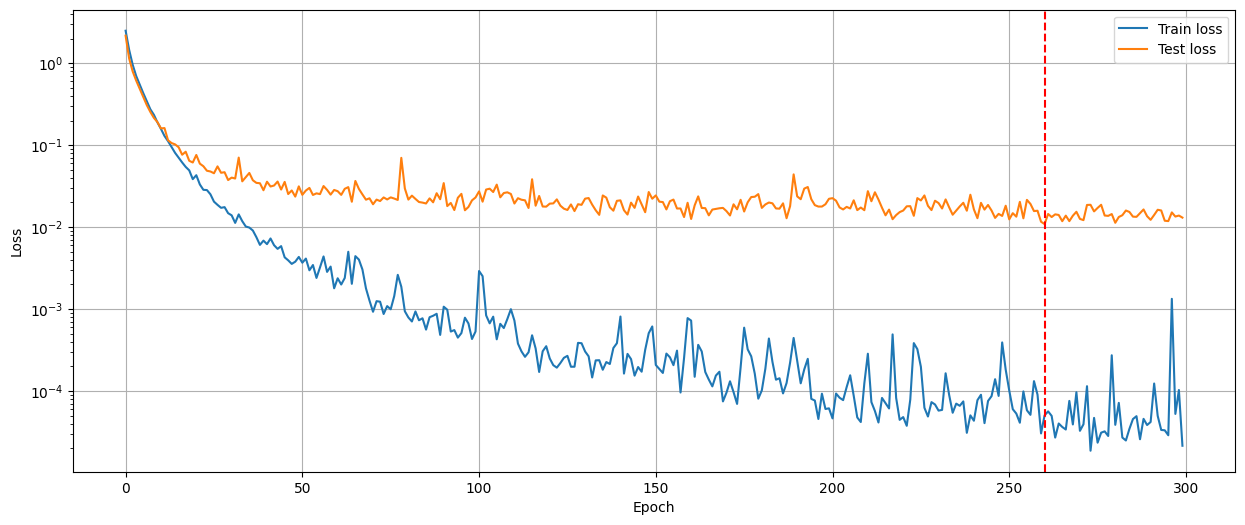

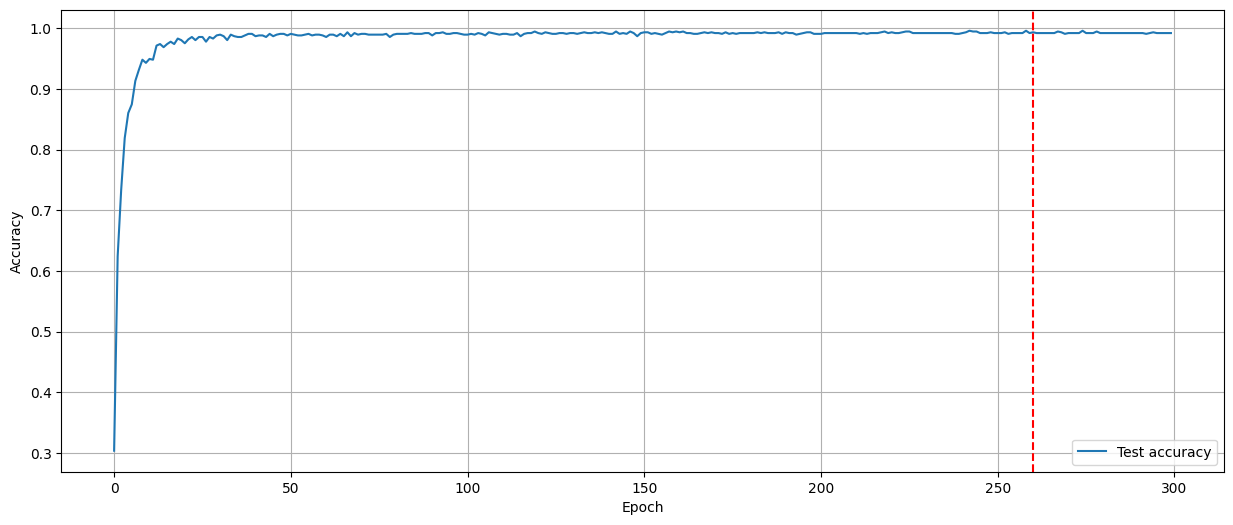

In [5]:
# Train domain classifier on Dp (RealWorld)


with open('data/realworld_128_3ch_4cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open('data/realworld_128_3ch_4cl_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= 10]
y = y[k >= 10]
k = k[k >= 10] - 10
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=5, num_classes=4, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = nn.CrossEntropyLoss()

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=300, name='domain_classifier_realworld_te')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

(9522, 3, 256) (9522,) (9522,)
(7617, 3, 256) (1905, 3, 256) (7617,) (1905,) (7617,) (1905,)
Epoch 1/300 - Train loss: 1.7760 - Test loss: 1.4054 - Test accuracy: 0.2604 - LR: 0.000100
Epoch 2/300 - Train loss: 1.3827 - Test loss: 1.3741 - Test accuracy: 0.3265 - LR: 0.000099
Epoch 3/300 - Train loss: 1.2820 - Test loss: 2.2773 - Test accuracy: 0.3291 - LR: 0.000099
Epoch 4/300 - Train loss: 0.9988 - Test loss: 3.9083 - Test accuracy: 0.2504 - LR: 0.000099
Epoch 5/300 - Train loss: 0.7869 - Test loss: 2.4210 - Test accuracy: 0.2829 - LR: 0.000098
Epoch 6/300 - Train loss: 0.6849 - Test loss: 0.7553 - Test accuracy: 0.6829 - LR: 0.000098
Epoch 7/300 - Train loss: 0.5743 - Test loss: 0.5787 - Test accuracy: 0.7585 - LR: 0.000098
Epoch 8/300 - Train loss: 0.4889 - Test loss: 1.8910 - Test accuracy: 0.3832 - LR: 0.000097
Epoch 9/300 - Train loss: 0.4200 - Test loss: 0.4744 - Test accuracy: 0.8021 - LR: 0.000097
Epoch 10/300 - Train loss: 0.3682 - Test loss: 0.4848 - Test accuracy: 0.8000 -

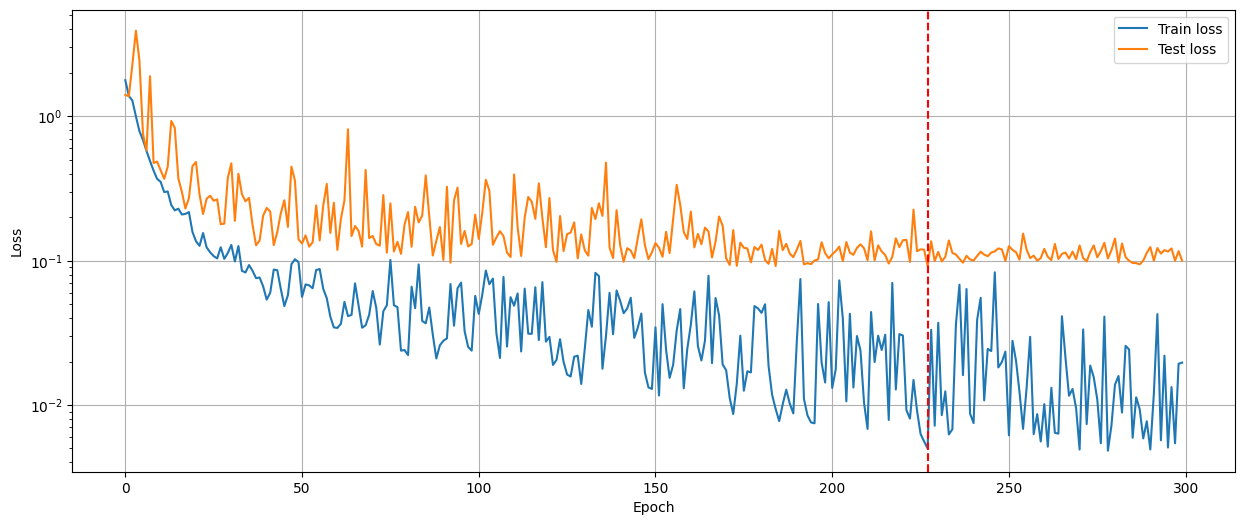

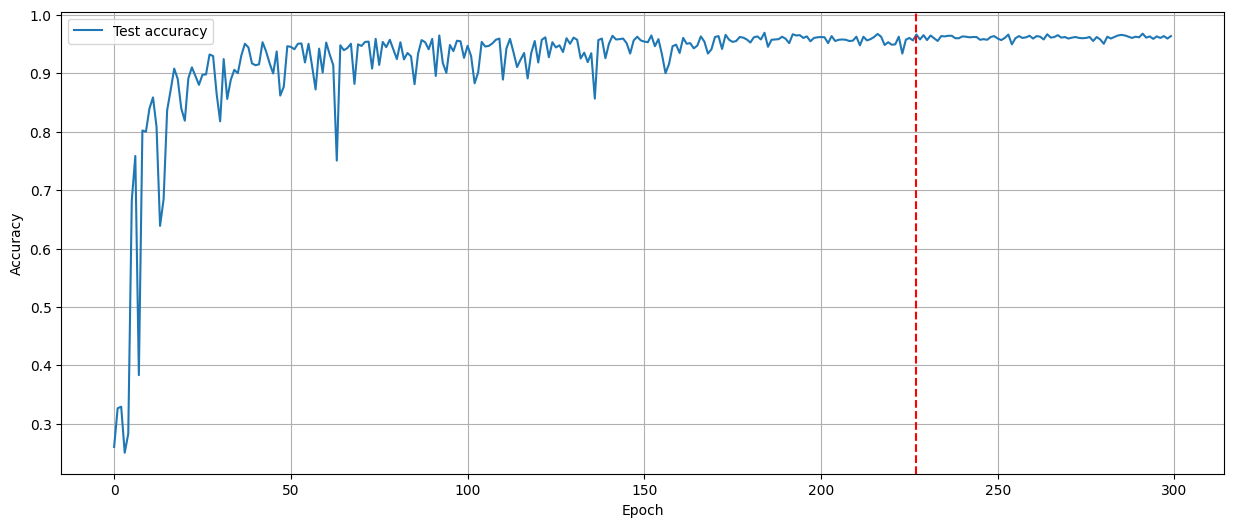

In [8]:
# Train domain classifier on Df (CWRU)


with open('data/cwru_256_3ch_5cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < 4]
y = y[k < 4]
k = k[k < 4]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=4, num_classes=5, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = nn.CrossEntropyLoss()

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=300, name='domain_classifier_cwru_tr')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

(9426, 3, 256) (9426,) (9426,)
(7540, 3, 256) (1886, 3, 256) (7540,) (1886,) (7540,) (1886,)
Epoch 1/300 - Train loss: 1.8991 - Test loss: 1.4019 - Test accuracy: 0.3245 - LR: 0.000100
Epoch 2/300 - Train loss: 1.3395 - Test loss: 1.4149 - Test accuracy: 0.2683 - LR: 0.000099
Epoch 3/300 - Train loss: 0.9962 - Test loss: 1.8534 - Test accuracy: 0.2948 - LR: 0.000099
Epoch 4/300 - Train loss: 0.7547 - Test loss: 1.9437 - Test accuracy: 0.3197 - LR: 0.000099
Epoch 5/300 - Train loss: 0.6004 - Test loss: 0.5676 - Test accuracy: 0.7524 - LR: 0.000098
Epoch 6/300 - Train loss: 0.4912 - Test loss: 0.4767 - Test accuracy: 0.7948 - LR: 0.000098
Epoch 7/300 - Train loss: 0.4042 - Test loss: 0.5185 - Test accuracy: 0.7651 - LR: 0.000098
Epoch 8/300 - Train loss: 0.3534 - Test loss: 0.9651 - Test accuracy: 0.6172 - LR: 0.000097
Epoch 9/300 - Train loss: 0.3144 - Test loss: 0.5653 - Test accuracy: 0.7529 - LR: 0.000097
Epoch 10/300 - Train loss: 0.2757 - Test loss: 0.9479 - Test accuracy: 0.6766 -

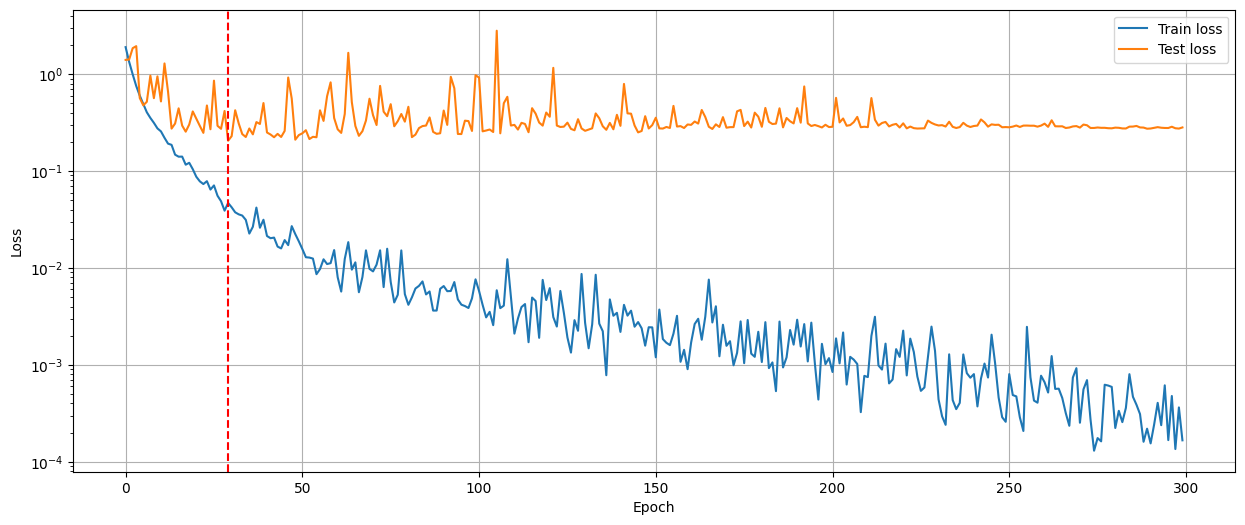

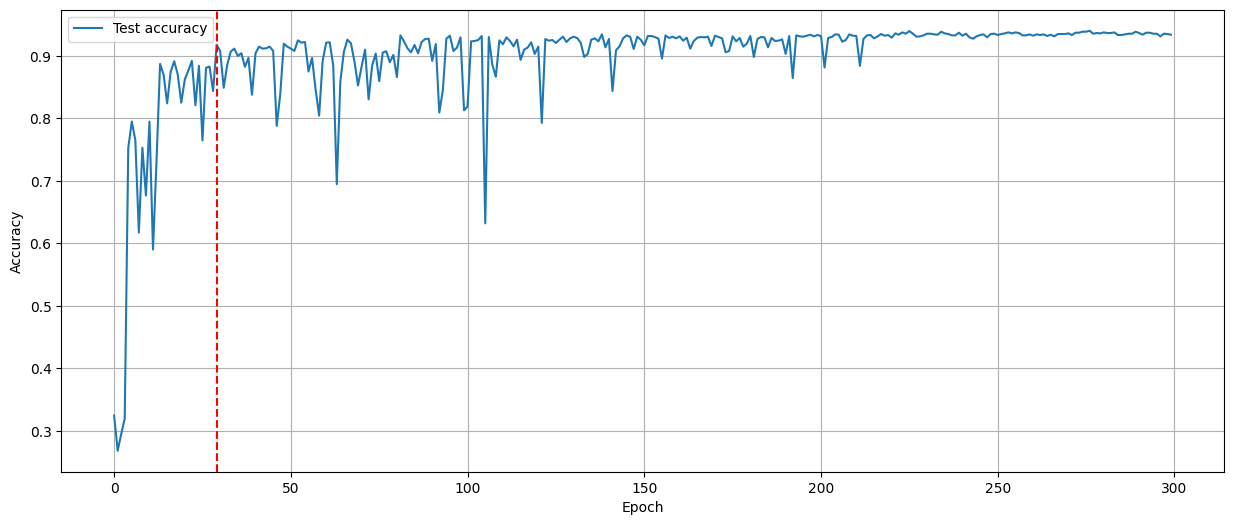

In [10]:
# Train domain classifier on Dp (CWRU)


with open('data/cwru_256_3ch_5cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open('data/cwru_256_3ch_5cl_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= 4]
y = y[k >= 4]
k = k[k >= 4] - 4
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=4, num_classes=5, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = nn.CrossEntropyLoss()

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=300, name='domain_classifier_cwru_te')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()